In [1]:
import numpy as np
import re
import itertools
from collections import Counter
import collections
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import ndarray as nd
from mxnet import autograd
import pickle
from mxnet.contrib import text
import matplotlib.pyplot as plt

In [2]:
def review_to_wordlist(review):
    string = review.lower()
    string = re.findall(r'(?u)\b\w\w+\b',string)
    return string
def build_input_data(x,y,vocab,max_length,padding_word='</s>'):
    padded_sentences = []
    for i in range(len(x)):
        sentence = x[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(vocab.to_indices(new_sentence))
    xd = np.array(padded_sentences)
    yd = np.array(y)
    return xd,yd

In [12]:
class ConvConcat(nn.HybridBlock):
    def __init__(self,sentence_size,num_embed,**kwargs):
        super(ConvConcat,self).__init__(**kwargs)
        net1 = nn.HybridSequential()
        with net1.name_scope():
            net1.add(nn.Conv2D(channels=100,kernel_size=(3,num_embed),activation='relu'))
            net1.add(nn.MaxPool2D(pool_size=(sentence_size-3+1,1)))

        net2 = nn.HybridSequential()
        with net2.name_scope():
            net2.add(nn.Conv2D(channels=100,kernel_size=(4,num_embed),activation='relu'))
            net2.add(nn.MaxPool2D(pool_size=(sentence_size-4+1,1)))
        
        net3 = nn.HybridSequential()
        with net3.name_scope():
            net3.add(nn.Conv2D(channels=100,kernel_size=(5,num_embed),activation='relu'))
            net3.add(nn.MaxPool2D(pool_size=(sentence_size-5+1,1)))
            
        net4 = nn.HybridSequential()
        with net4.name_scope():
            net4.add(nn.Conv2D(channels=100,kernel_size=(6,num_embed),activation='relu'))
            net4.add(nn.MaxPool2D(pool_size=(sentence_size-6+1,1)))
        
        self.net1 = net1
        self.net2 = net2
        self.net3 = net3
        self.net4 = net4
    def hybrid_forward(self,F,x):
        pooled_outputs = []
        pooled_outputs.append(self.net1(x))
        pooled_outputs.append(self.net2(x))
        pooled_outputs.append(self.net3(x))
        pooled_outputs.append(self.net4(x))
        
        total_filters = 100 * 4
        concat = F.Concat(*pooled_outputs, dim=1)
        h_pool = F.reshape(concat, (-1, total_filters))
        
        return h_pool

class ReshapeInput(nn.HybridBlock):
    def __init__(self,sentence_size,num_embed,**kwargs):
        super(ReshapeInput,self).__init__(**kwargs)
        self.sentence_size = sentence_size
        self.num_embed = num_embed
    def hybrid_forward(self,F,x):
        return F.reshape(x,(-1,1,self.sentence_size,self.num_embed))

def accuracy(output, label):
    return np.mean(output.argmax(axis=1)==label)

def get_valid_acc(net,valid):
    valid_acc = 0.
    bad_label = []
    for data,label in valid:
        output = net(data.as_in_context(mx.gpu()))
        acc = accuracy(nd.softmax(output).asnumpy(),label.asnumpy())
        if acc != 1.0:
            bad_label.append(label[0])
        valid_acc +=acc
    return valid_acc/len(valid),bad_label

In [4]:
sequence_length = 400

In [5]:
test_data,test_label = pickle.load(open('./test','rb'))

tsd = []
for d in test_data:
    rad = review_to_wordlist(d)
    if len(rad) > sequence_length:
        rad = rad[:sequence_length]
    tsd.append(rad)

del test_data
test_data = tsd
del tsd

In [6]:
label_vocab = pickle.load(open('./label_vocab','rb'))
data_vocab = pickle.load(open('./data_vocab','rb'))

In [7]:
test_labels = label_vocab.to_indices(test_label)
test_data, test_labels = build_input_data(test_data, test_labels, data_vocab,sequence_length)
test_labels = test_labels -1

test_x = nd.array(test_data)
test_y = nd.array(test_labels)
del test_data
del test_labels

In [8]:
net = nn.HybridSequential()
with net.name_scope():
    net.add(nn.Embedding(len(data_vocab), 300))
    net.add(ReshapeInput(sequence_length,300))
    net.add(ConvConcat(sequence_length,300))
    net.add(nn.Dropout(.5))
    net.add(nn.Dense(20))
net.load_params('./params/0.8529723991507431_params',ctx=mx.gpu())
net.hybridize()

In [9]:
valid_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_x,test_y), batch_size=1,shuffle=True)

In [13]:
valid_acc,bad_label = get_valid_acc(net,valid_data)
print(valid_acc)

0.85302708444


In [14]:
def label_vew(label):
    label_dic ={}
    for l in label:
        ll = label_vocab.idx_to_token[int(l.asscalar())-1]
        if ll not in label_dic:
            label_dic[ll] = 0
        label_dic[ll] +=1
    char_to_idx = dict([(char, i) for i, char in enumerate(label_dic.keys())])
    y = []
    yk = []
    x= []
    for yy in label_dic.keys():
        y.append(char_to_idx[yy])
        yk.append(yy)
        x.append(label_dic[yy])
    plt.figure(figsize=(9,6),dpi=100)
    plt.barh(y,x)
    plt.yticks(range(20),yk)
    plt.show()

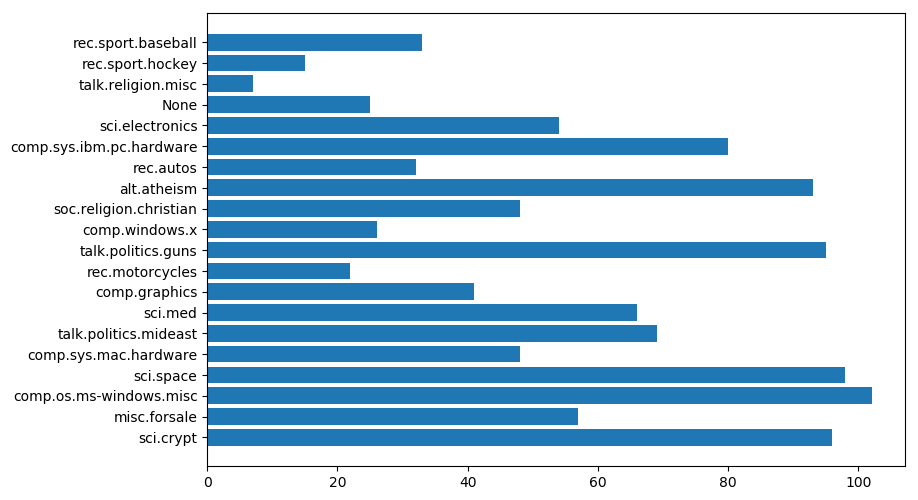

In [15]:
label_vew(bad_label)